In [1]:
import string
import pickle
import time
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report,
    make_scorer
)

import joblib

from IPython.display import display

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)

# **Data Preprocessing**

In [2]:
with open('query.txt', 'r', encoding='utf-8') as f:
    queries = f.readlines()

with open('payload.txt', 'r', encoding='utf-8') as f:
    payloads = f.readlines()

queries = [q.strip() for q in queries if q.strip()]
payloads = [p.strip() for p in payloads if p.strip()]

data = [q.split("::::") for q in queries]
queries = [d[0] for d in data]
labels = [int(d[1]) for d in data]

query_df = pd.DataFrame({'query': queries, 'label': labels})
payload_df = pd.DataFrame({'payload': payloads})

# query_df.head()
# payload_df.head()

print(query_df.shape)
print(payload_df.shape)

print(query_df[query_df['label'] == 1].count())
print(query_df[query_df['label'] == 0].count())

(1004, 2)
(37, 1)
query    203
label    203
dtype: int64
query    801
label    801
dtype: int64


# **Feature Extraction**

In [3]:
class FeatureExtractor:
    def __init__(self, payload_list):
        self.payload_list = [p.translate({ord(c): None for c in string.whitespace}) for p in payload_list]

    def extract_features(self, query):
        temp_query = query.translate({ord(c): None for c in string.whitespace})

        # Feature 1: Contains Empty String
        def contains_empty_string(query):
          return int("\"\"" in query or "''" in query)

        # Feature 2: Contains Injection Payload
        def contains_injection_payload(query):
          return int(any(p in temp_query for p in self.payload_list))

        # Feature 3: Contains Comparison
        def contains_comparison(query):
          condition = [
            "find(", "$selector", "find.sort(", "$eq", "$gt", "$gte",
            "$ne", "$lt", "$lte", "$in", "$nin"
          ]
          return int(any(c in query for c in condition))

        # Featute 4: Contains Logical Operator
        def contains_logical_operator(query):
          return int(any(op in query for op in ["$or", "$and", "$not", "$nor"]))

        # Feature 5: Contains Evaluation Query Operation
        def contains_evaluation_query_operation(query):
          return int(any(op in temp_query for op in ["$mod", "$regex", "$text", "$where"]))

        # Feature 6: Presence of return
        def contains_return(query):
          return int(";return" in query or "return 1" in query or "return true" in query or "return(true)" in query)

        # Feature 7: New Query
        def is_new_query(query):
          return int(";db." in query)

        # Feature 8: Contains Always True Expression (regex-based attack)
        def contains_regex_true(query):
          return int(any(r in temp_query for r in ["/.*/", "/./", "/."]))

        # Feature 9: Contains Element Query Operations
        def contains_element_query_operations(query):
          return int(any(op in temp_query for op in ["$exists", "$type"]))

        # Feature 10: Contains Null comparison
        def contains_null_comparison(query):
          return int("null" in query)

        # Feature 11: Alters Collection
        def does_alter_collection(query):
          # return int("createCollection(" in query or "drop(" in query)
          return int(any(op in query for op in ["createCollection(", "drop(", "createTable()", "showTable()"]))

        # Feature 12: Drop Database
        def does_drop_database(query):
          return int("dropDatabase(" in query)

        # Feature 13: Update Query
        def does_update_query(query):
          return int(any(op in query for op in ["update(", "save("]))

        # Feature 14: Contain Remove Query
        def does_remove_query(query):
          return int("remove(" in query)

        # Feature 15: Contain Limit Keyword
        def contain_limit(query):
          return int("limit" in query)

        # Feature 16: Infinite Loop
        def is_while_true(query):
          return int("while(true)" in query)

        features = [
            contains_empty_string(query),
            contains_injection_payload(query),
            contains_comparison(query),
            contains_logical_operator(query),
            contains_evaluation_query_operation(query),
            contains_return(query),
            is_new_query(query),
            contains_regex_true(query),
            contains_element_query_operations(query),
            contains_null_comparison(query),
            does_alter_collection(query),
            does_drop_database(query),
            does_update_query(query),
            does_remove_query(query),
            contain_limit(query),
            is_while_true(query),
        ]
        return features

In [4]:
extractor = FeatureExtractor(payload_list = payloads)

features = query_df['query'].apply(extractor.extract_features)

feature_name = [
    '1. Contains Empty String',
    '2. Contains Injection Payload',
    '3. Contains Comparison',
    '4. Contains Logical Operator',
    '5. Contains Evaluation Query Operation',
    '6. Presence of return',
    '7. New Query',
    '8. Contains Always True Expression',
    '9. Contains Element Query Operations',
    '10. Contains Null Comparison',
    '11. Alters Collection',
    '12. Drop Database',
    '13. Update Query',
    '14. Remove Query',
    '15. Contain Limit Keyword',
    '16. Infinite Loop'
]

temp = pd.DataFrame(features.tolist(), columns=feature_name)

feature_df = pd.concat([temp, query_df['label']], axis=1)

# feature_df.head()

feature_df.sum(axis=0)

1. Contains Empty String                   62
2. Contains Injection Payload             101
3. Contains Comparison                    644
4. Contains Logical Operator              167
5. Contains Evaluation Query Operation    102
6. Presence of return                      18
7. New Query                               60
8. Contains Always True Expression         22
9. Contains Element Query Operations        9
10. Contains Null Comparison               30
11. Alters Collection                      10
12. Drop Database                           3
13. Update Query                           96
14. Remove Query                           10
15. Contain Limit Keyword                  31
16. Infinite Loop                           2
label                                     203
dtype: int64

In [5]:
feature_df.to_csv('feature_df.csv', index=False)


# **Feature Selection**

In [6]:
X = feature_df.drop(columns=['label']) # input features
y = feature_df['label'] # output label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# information gain
mutual_info = mutual_info_classif(X_train, y_train, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

# chi square test
chi2_score = chi2(X_train, y_train)
chi2_score = pd.Series(chi2_score[0])
chi2_score.index = X_train.columns
chi2_score.sort_values(ascending=False)

combined_scores = pd.DataFrame({
    'Information Gain': mutual_info,
    'Chi-Square Score': chi2_score
})

# combined_scores.sort_values(by='Information Gain', ascending=False)
combined_scores.sort_values(by='Chi-Square Score', ascending=False)

,Information Gain,Chi-Square Score
1. Contains Empty String,0.074082,157.764829
7. New Query,0.070437,136.882454
5. Contains Evaluation Query Operation,0.075133,116.932619
8. Contains Always True Expression,0.028733,69.949045
2. Contains Injection Payload,0.009339,35.093565
3. Contains Comparison,0.065337,25.882820
6. Presence of return,0.006830,24.621779
10. Contains Null Comparison,0.000000,10.636749
13. Update Query,0.000000,10.316524
16. Infinite Loop,0.019243,8.229299


In [7]:
# select top num features using Chi-Square Test
num = 12 # best number of features
chi2_selector = SelectKBest(score_func=chi2, k=num)
X_kbest = chi2_selector.fit_transform(X, y)

selected_features = X.columns[chi2_selector.get_support()]

X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

selected_features.tolist()

['1. Contains Empty String',
 '2. Contains Injection Payload',
 '3. Contains Comparison',
 '4. Contains Logical Operator',
 '5. Contains Evaluation Query Operation',
 '6. Presence of return',
 '7. New Query',
 '8. Contains Always True Expression',
 '10. Contains Null Comparison',
 '12. Drop Database',
 '13. Update Query',
 '16. Infinite Loop']

# **SMOTE**

In [8]:
print('Before SMOTE:')
print('Non-injection(0):', sum(y == 0))
print('Injection(1):', sum(y == 1))

smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print('\nAfter SMOTE:')
print('Non-injection(0):', sum(y_resampled == 0))
print('Injection(1):', sum(y_resampled == 1))

Before SMOTE:
Non-injection(0): 801
Injection(1): 203

After SMOTE:
Non-injection(0): 646
Injection(1): 646


# **Train the Models**

In [9]:
# Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}
grid_svm = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(64, 32), (128, 64, 32), (256, 128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.01, 0.001, 0.05],
    'max_iter': [1000, 2000, 3000],
}
grid_nn = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid=param_grid_nn,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [1, 2, 3]
}
grid_xgb = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME']
}
grid_ada = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid_ada,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced']
}
grid_lr = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_lr,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

best_models = {
    'Decision Tree': grid_dt,
    'Random Forest': grid_rf,
    'SVM': grid_svm,
    'Neural Network': grid_nn,
    'XGBoost': grid_xgb,
    'AdaBoost': grid_ada,
    'Logistic Regression': grid_lr,
    'Naive Bayes': BernoulliNB(),
    'k-NN': grid_knn
}
results = []
f2_score = make_scorer(fbeta_score, beta=2)
best_model_name = None
best_model_instance = None
best_f2_score = 0
all_params = {} # store all best parameters of each model


for name, model in best_models.items():
    print(f'Training {name} with 10-fold cross validation')

    start_time = time.time()
    
    scores = cross_validate(
        model,
        X_resampled,
        y_resampled,
        cv=10,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'f2': f2_score
        },
        n_jobs=-1
    )
    training_time = time.time() - start_time

    current_f2_score = scores['test_f2'].mean()
    
    result = {
        'Model': name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        # 'F1 Score': scores['test_f1'].mean(),
        'F2 Score': current_f2_score,
        'Training Time(s)': training_time
    }
    results.append(result)
    
    # Track the model with the highest F2 score
    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model_name = name
        best_model_instance = model
    
    if name != 'Naive Bayes':
        model.fit(X_resampled, y_resampled)
        all_params[name] = model.best_params_ if hasattr(model, 'best_params_') else None
    else:
        all_params[name] = None

Training Decision Tree with 10-fold cross validation
Training Random Forest with 10-fold cross validation
Training SVM with 10-fold cross validation
Training Neural Network with 10-fold cross validation
Training XGBoost with 10-fold cross validation
Training AdaBoost with 10-fold cross validation
Training Logistic Regression with 10-fold cross validation
Training Naive Bayes with 10-fold cross validation
Training k-NN with 10-fold cross validation


In [10]:
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)
display(results_df)

,Model,Accuracy,Precision,Recall,F2 Score,Training Time(s)
0,Decision Tree,0.931902,0.937656,0.925769,0.928029,4.941022
1,Random Forest,0.933435,0.937979,0.928846,0.930520,45.439188
2,SVM,0.914854,0.901022,0.933510,0.926582,0.898922
3,Neural Network,0.924925,0.923702,0.927308,0.926438,730.765598
4,XGBoost,0.681151,0.614003,0.979904,0.875360,167.181070
5,AdaBoost,0.909434,0.925681,0.891635,0.897846,6.924897
6,Logistic Regression,0.926476,0.930230,0.922668,0.924059,0.371000
7,Naive Bayes,0.922612,0.925704,0.919591,0.920676,0.028527
8,k-NN,0.900900,0.963544,0.834471,0.856315,2.180207


In [11]:
# print(all_params)

for name, params in all_params.items():
    print(f'Model: {name}')
    if params:
        for param, value in params.items():
            print(f'{param}: {value}')
    else:
        print('Default setting')
    print('\n')    

Model: Decision Tree
criterion: gini
max_depth: 10
min_samples_leaf: 1
min_samples_split: 2


Model: Random Forest
class_weight: balanced
max_depth: 5
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100


Model: SVM
C: 0.1
class_weight: balanced
gamma: scale
kernel: rbf


Model: Neural Network
activation: tanh
hidden_layer_sizes: (64, 32)
learning_rate_init: 0.05
max_iter: 1000
solver: adam


Model: XGBoost
colsample_bytree: 0.7
learning_rate: 0.01
max_depth: 3
n_estimators: 100
scale_pos_weight: 3
subsample: 0.7


Model: AdaBoost
algorithm: SAMME
learning_rate: 1.0
n_estimators: 200


Model: Logistic Regression
C: 1
class_weight: balanced
solver: liblinear


Model: Naive Bayes
Default setting


Model: k-NN
algorithm: auto
n_neighbors: 7
weights: distance




In [12]:
from sklearn.metrics import classification_report

best_dt = grid_dt.best_estimator_
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_
best_nn = grid_nn.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_ada = grid_ada.best_estimator_
best_lr = grid_lr.best_estimator_
best_nb = BernoulliNB().fit(X_resampled, y_resampled)
best_knn = grid_knn.best_estimator_

# evaluate on the test set
print("Decision Tree on Test Set:")
y_pred_dt = best_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

print("\nRandom Forest on Test Set:")
y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

print("\nSVM on Test Set:")
y_pred_svm = best_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

print("\nNeural Network on Test Set:")
y_pred_nn = best_nn.predict(X_test)
print(classification_report(y_test, y_pred_nn))

print("\nXGBoost on Test Set:")
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

print("\nAdaBoost on Test Set:")
y_pred_ada = best_ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

print("\nLogistic Regression on Test Set:")
y_pred_lr = best_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

print("\nNaive Bayes on Test Set:")
y_pred_nb = best_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

print("\nk-NN on Test Set:")
y_pred_knn = best_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

Decision Tree on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       155
           1       0.78      0.87      0.82        46

    accuracy                           0.92       201
   macro avg       0.87      0.90      0.88       201
weighted avg       0.92      0.92      0.92       201


Random Forest on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       155
           1       0.78      0.87      0.82        46

    accuracy                           0.92       201
   macro avg       0.87      0.90      0.88       201
weighted avg       0.92      0.92      0.92       201


SVM on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       155
           1       0.77      0.87      0.82        46

    accuracy                           0.91       201
   macro avg       0.86      0.90      0.88       201
w

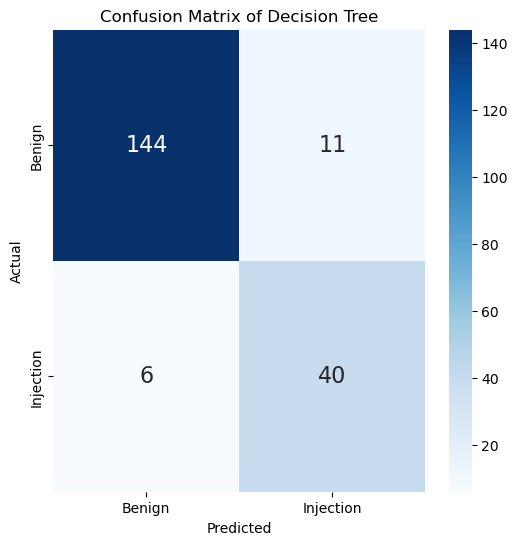

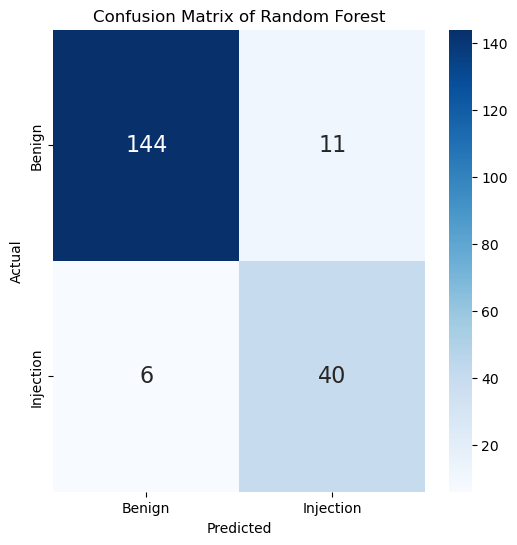

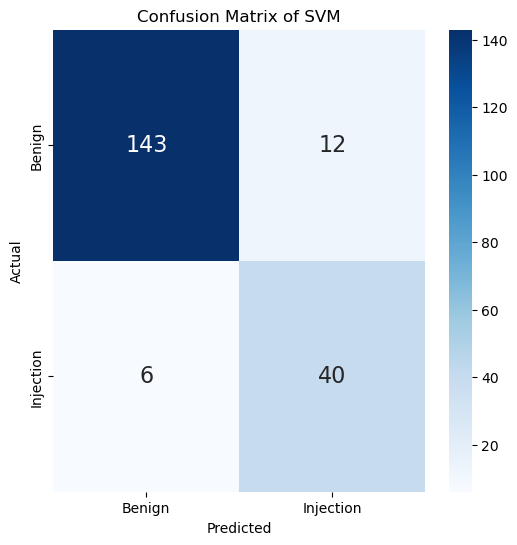

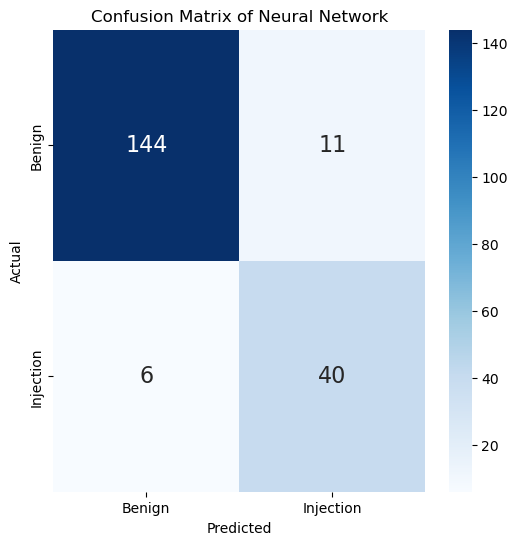

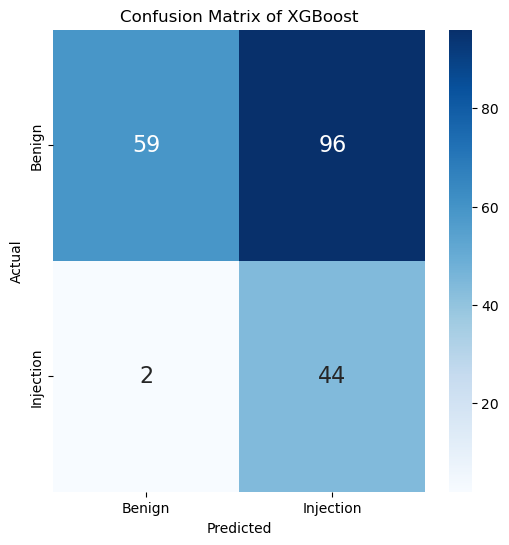

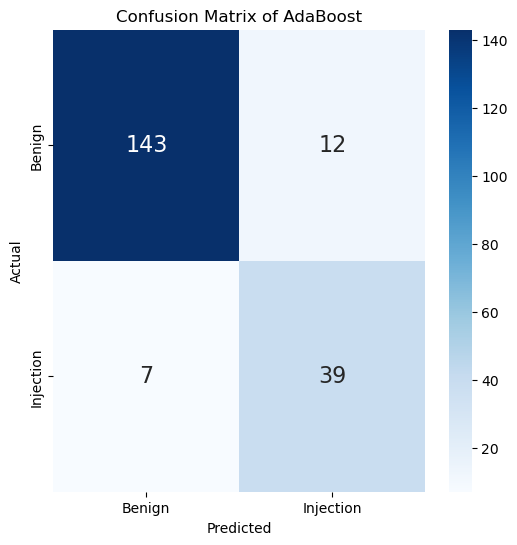

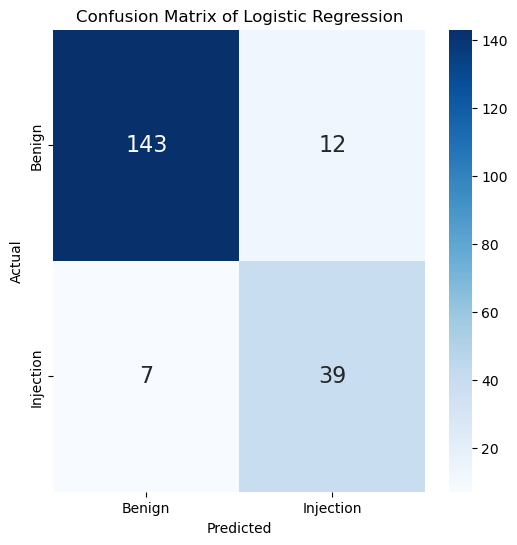

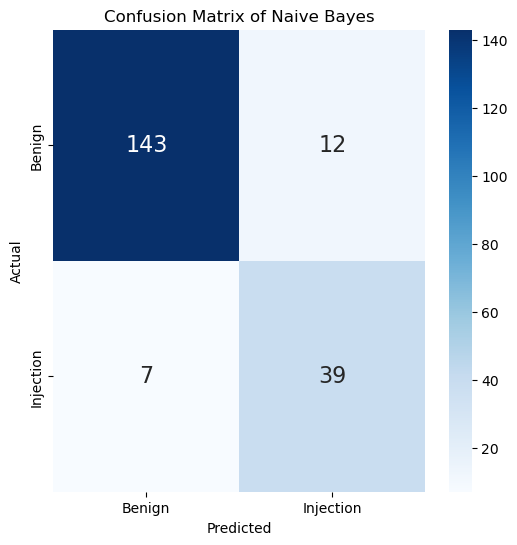

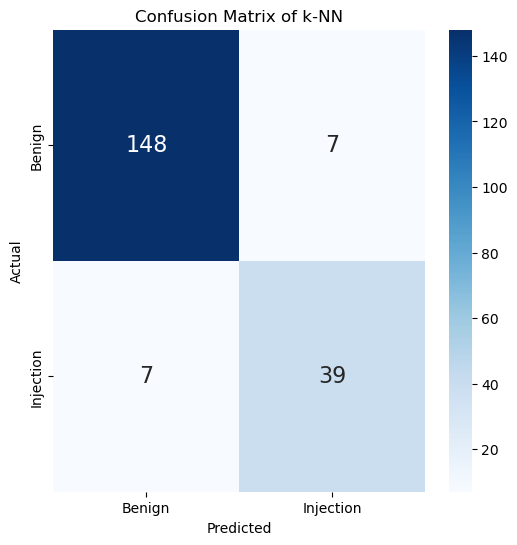

In [13]:
# confusion matrix for each model

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, xticklabels=["Benign", "Injection"], yticklabels=["Benign", "Injection"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix of {model_name}')
    plt.show()
    
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree')
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')
plot_confusion_matrix(y_test, y_pred_svm, 'SVM')
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network')
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')
plot_confusion_matrix(y_test, y_pred_ada, 'AdaBoost')
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression')
plot_confusion_matrix(y_test, y_pred_nb, 'Naive Bayes')
plot_confusion_matrix(y_test, y_pred_knn, 'k-NN')


In [14]:
print(best_model_name)
print(best_model_instance)
print(all_params[best_model_name])
print(best_f2_score)

Random Forest
GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='recall')
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.9305196211743203


In [15]:
best_rf_model_data = {
    'model_name': best_model_name,
    'model': best_model_instance,
    'best_params': all_params[best_model_name]
}

joblib.dump(best_rf_model_data, 'best_model.pkl')

best_rf_model = joblib.load('best_model.pkl')
for key, value in best_rf_model.items():
    print(f'{key}: {value}')

model_name: Random Forest
model: GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='recall')
best_params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# **Testing**

In [16]:
load_rf_model = joblib.load('random_forest_model.pkl')
model = load_rf_model['model']

test_query = "db.users.find({\"$where\": \"this.password == 'admin'\"})"

test_query_features = extractor.extract_features(test_query)
test_query_df = pd.DataFrame([test_query_features], columns=feature_name)
test_query_selected = test_query_df[selected_features]
prediction = model.predict(test_query_selected)
prediction_prob = model.predict_proba(test_query_selected)


print(f'Query: {test_query}')
print('Prediction:', 'Injection' if prediction[0] == 1 else 'Non-Injection')
print(f"Prediction Probabilities [Benign, Injection]: {prediction_prob[0]}")

Query: db.users.find({"$where": "this.password == 'admin'"})
Prediction: Injection
Prediction Probabilities [Benign, Injection]: [0.35610147 0.64389853]


In [17]:
import joblib

load_rf_model = joblib.load('random_forest_model.pkl')
model = load_rf_model['model']

with open('test_query.txt', 'r', encoding='utf-8') as f:
    test_queries = f.readlines()

test_queries = [q.strip() for q in test_queries if q.strip()]
test_data = [q.split('::::') for q in test_queries]
test_queries = [d[0] for d in test_data]
test_labels = [int(d[1]) for d in test_data]

test_features = [extractor.extract_features(query) for query in test_queries]
test_features_df = pd.DataFrame(test_features, columns=feature_name)
test_features_selected = test_features_df[selected_features]

test_predictions = model.predict(test_features_selected)
test_prediction_probs = model.predict_proba(test_features_selected)

count = 0

for i, query in enumerate(test_queries):
    print(f'Query: {query}')
    print('Prediction:', 'Injection' if test_predictions[i] == 1 else 'Non-Injection')
    print(f'Prediction Probabilities [Benign, Injection]: {test_prediction_probs[i]}')
    print(f'Actual Label: {'Injection' if test_labels[i] == 1 else 'Non-Injection'}')
    print('\n')
    
    if test_predictions[i] == test_labels[i]:
        count += 1
        
print(f'Accuracy: {count / len(test_queries) * 100:.2f}%')

Query: db.products.find({ category: "electronics", price: { $lt: 500 } })
Prediction: Non-Injection
Prediction Probabilities [Benign, Injection]: [0.64890708 0.35109292]
Actual Label: Non-Injection


Query: db.admins.find({ role: "admin", $or: [ {}, { access: "full" } ] })
Prediction: Injection
Prediction Probabilities [Benign, Injection]: [0.36510232 0.63489768]
Actual Label: Injection


Query: db.sessions.find({ $where: "this.active == true; sleep(10000)" })
Prediction: Injection
Prediction Probabilities [Benign, Injection]: [0.15480637 0.84519363]
Actual Label: Injection


Query: db.books.find({ author: "Jane Austen", published_year: 1813 })
Prediction: Non-Injection
Prediction Probabilities [Benign, Injection]: [0.64890708 0.35109292]
Actual Label: Non-Injection


Query: db.collection.find({ $where: "this.name == ''; return true" })
Prediction: Injection
Prediction Probabilities [Benign, Injection]: [0.02396385 0.97603615]
Actual Label: Injection


Query: db.users.find({ username: 